# Transcriptional Frontloading
Following Barshis et al 2010, Gurr et al 2022, and Collins et al 2020

### general pipeline:
1. identify stress-inducible genes in control/naive oysters (uniquely DE in CS vs. CC, where S is a stressor)
    - separate up- and down-regulated DEGs
2. calculate mean vst expression for each treatment combo (CC, CS, SC, SS)
3. calculate baseline frontloading - "control ratio" - (SC / CC) with vst counts (y-axis)
4. calculate ratio of stress response - "response ratio" - ( (SS / SC) / CS / CC) ) with vst counts (x-axis)
5. plot!

## data prep:

### 1. load libraries

In [64]:
library(tidyverse)
library(cowplot)

### 2. read CSVs

#### DEGs

In [11]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs',
    pattern = '\\.csv$',
    full.names = TRUE
    )

# read each csv
deg_list <- lapply(files, read.csv)

# name list elements after the files
names(deg_list) <- gsub('DEG_','',tools::file_path_sans_ext(basename(files)))

# check things worked
names(deg_list)
head(deg_list$bb_cc)

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111134671,625.01171,1.753537,1.7854969,-3.896541,9.757625e-05,0.024809138,0.129437417,1630.363493,396.72563,⋯,343.310528,47.154920,18.39813,182.5864,1589.761857,113.04282,34.431967,365.533797,CC vs. BB,BB
2,LOC111120923,150.61422,-4.437657,4.2249639,3.936072,8.282599e-05,0.022257298,0.114534769,10.312823,5059.99177,⋯,184.094051,9.029665,0.00000,401.0569,185.203805,39.89747,5.379995,9.563384,CC vs. BB,CC
3,LOC111136853,88.45293,-1.689220,2.4561034,3.707079,2.096634e-04,0.041250020,0.227646483,2.812588,216.75736,⋯,3.731636,16.052739,0.00000,0.0000,6.902005,17.73221,2.151998,21.251965,CC vs. BB,CC
4,LOC111120760,106.14900,2.650952,0.8725114,-4.677419,2.905087e-06,0.001454877,0.006079963,62.814465,34.80049,⋯,31.096968,91.299951,198.69983,103.4305,81.673728,44.33052,40.887961,86.070458,CC vs. BB,BB
5,LOC111107221,5.76896,17.541870,4.0010929,-4.971174,6.654857e-07,0.000366605,0.001639387,0.000000,0.00000,⋯,0.000000,0.000000,0.00000,0.0000,0.000000,0.00000,0.000000,0.000000,CC vs. BB,BB
6,LOC111125595,126.64678,15.441532,9.9678950,-4.160631,3.173698e-05,0.011188080,0.039860365,493.140424,0.00000,⋯,0.000000,0.000000,0.00000,0.0000,0.000000,0.00000,0.000000,0.000000,CC vs. BB,BB


#### all genes

In [13]:
# get list of files
files_all <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes',
    pattern = '\\.csv$',
    full.names = TRUE
    )

# read each csv
all_list <- lapply(files_all, read.csv)

# name list elements after the files
names(all_list) <- tools::file_path_sans_ext(basename(files_all))

# check things worked
names(all_list)
head(all_list$bb_cc)

#### vst counts

In [10]:
vsd <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_vstCounts.csv') %>%
column_to_rownames('X')
head(vsd)

,B1_B1_O01,B1_W5_O50,B2_B5_O51,B2_C4_O40,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,B3_W1_O06,B3_W4_O41,⋯,W4_W5_G56,W5_B2_G21,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC111116054,7.692872,7.805746,7.871959,7.843091,7.548551,7.909124,7.947895,7.869635,7.840134,7.758281,⋯,7.767900,7.713596,7.900466,7.697844,7.834121,7.790482,7.708399,8.030152,7.657898,7.548551
LOC111126949,10.197580,9.653169,9.900281,9.718856,9.612738,9.545333,9.334530,9.803992,9.906070,9.592360,⋯,9.078093,9.779869,9.712370,10.082883,9.950378,9.563392,9.665533,9.644851,9.276775,9.929224
LOC111110729,8.354765,8.542687,8.351593,8.513945,8.518601,8.653091,8.816678,8.937210,8.568640,8.590933,⋯,8.714150,8.368627,8.514299,8.798284,8.635108,8.680883,8.780214,8.673395,8.746416,9.064164
LOC111112434,7.886383,7.697174,7.548551,7.687586,7.940109,7.989592,7.818256,8.186828,7.658920,7.879728,⋯,7.817069,7.548551,7.937395,7.806904,7.750644,7.548551,7.708399,7.990820,7.857315,7.548551
LOC111120752,9.363550,9.355360,9.509373,9.284512,9.198871,9.337765,9.699834,9.473806,8.989457,9.167603,⋯,9.549481,9.234610,9.599548,9.383933,9.510347,9.253648,9.345876,9.627837,9.412129,9.619853
LOC111128944,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,⋯,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551,7.548551


this is for individual samples, so will need to average across sample

## frontloading analysis

### 1. stress-inducible genes
genes uniquely DE in phase 1 control/naive oysters

for hypoxia, these are DEGs in CH vs. CC (and not in HH vs. HC)

In [18]:
hyp.uniq <- deg_list$ch_cc[!deg_list$ch_cc$Gene %in% deg_list$hh_hc$Gene, ]
dim(hyp.uniq) # 203 unique DEGs

# upregulated genes
hyp.uniq_UP <- hyp.uniq %>% filter(log2FoldChange > 0)
dim(hyp.uniq_UP) # 62 upregulated

# downregulated genes
hyp.uniq_DOWN <- hyp.uniq %>% filter(log2FoldChange < 0)
dim(hyp.uniq_DOWN) # 141 downregulated

[1] 203 104

[1]  62 104

[1] 141 104

In [19]:
head(hyp.uniq_DOWN)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111119645,543.131588,-2.642393,3.092662,-3.791946,1.494712e-04,2.867316e-02,0.1239672568,1710.053485,27.84039,⋯,6.219394,187.616382,135.2263,8.443304,6.902005,16.62394,30.127971,46.754323,CC vs. CH,CC
2,LOC111116296,466.599152,-4.795858,3.894749,-3.966035,7.307828e-05,1.623679e-02,0.0632262942,0.000000,0.00000,⋯,2.487757,60.197770,0.0000,4.221652,103.530077,0.00000,0.000000,2.125196,CC vs. CH,CC
3,LOC111105495,3.174899,-18.451623,11.357256,-4.070549,4.690239e-05,1.114403e-02,0.0278721628,0.000000,0.00000,⋯,4.975515,0.000000,0.0000,0.000000,0.000000,110.82630,0.000000,0.000000,CC vs. CH,CC
4,LOC111122352,2.183255,-16.084705,3.171951,-5.253215,1.494670e-07,6.172989e-05,0.0001460690,0.000000,0.00000,⋯,0.000000,7.023073,0.0000,2.110826,0.000000,0.00000,0.000000,2.125196,CC vs. CH,CC
5,LOC111123472,227.831737,-25.198248,5.210882,-5.189911,2.103947e-07,8.298770e-05,0.0002029509,0.000000,0.00000,⋯,603.281182,0.000000,0.0000,842.219545,0.000000,0.00000,0.000000,2.125196,CC vs. CH,CC
6,LOC111136853,88.452932,-6.204819,2.112541,-4.541727,5.579521e-06,1.733355e-03,0.0048374096,2.812588,216.75736,⋯,3.731636,16.052739,0.0000,0.000000,6.902005,17.73221,2.151998,21.251965,CC vs. CH,CC


### 2. calculate mean vst expression for each treatment combo


In [16]:
metaData <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
mutate(All_treatment = factor(paste0(Phase1_treatment, '_', Phase2_treatment))) %>% # add column for p1 and p2 treatment combined, make treatment groups a factor
filter(!is.na(Phase2_treatment)) %>% # remove phase 1 samples
select(Sample, All_treatment) # grab only the needed columns 

dim(metaData)
head(metaData)

[1] 96  2

,Sample,All_treatment
,<chr>,<fct>
1,B1_B1_O01,both_both
2,B1_W5_O50,both_warm
3,B2_B5_O51,both_both
4,B2_C4_O40,both_control
5,B3_B4_O41,both_both
6,B3_C3_O30,both_control


In [24]:
# convert vsd to long format
vsd.df <- as.data.frame(vsd)            # convert matrix to data frame
vsd.df$Gene <- rownames(vsd.df)            # keep gene names as a column

# Convert to long format
vsd_long <- vsd.df %>%
  pivot_longer(
    cols = -Gene,            # all columns except Gene
    names_to = "Sample",     # name of the column for sample names
    values_to = "Expression" # name of the column for values
  )

head(vsd_long)

Gene,Sample,Expression
<chr>,<chr>,<dbl>
LOC111116054,B1_B1_O01,7.692872
LOC111116054,B1_W5_O50,7.805746
LOC111116054,B2_B5_O51,7.871959
LOC111116054,B2_C4_O40,7.843091
LOC111116054,B3_B4_O41,7.548551
LOC111116054,B3_C3_O30,7.909124


In [26]:
meta_vsd <- merge(vsd_long, metaData, by = 'Sample')
head(meta_vsd)

,Sample,Gene,Expression,All_treatment
,<chr>,<chr>,<dbl>,<fct>
1,B1_B1_O01,LOC111116054,7.692872,both_both
2,B1_B1_O01,LOC111100350,8.035853,both_both
3,B1_B1_O01,LOC111132777,10.868664,both_both
4,B1_B1_O01,LOC111124849,8.653606,both_both
5,B1_B1_O01,LOC111133322,9.363550,both_both
6,B1_B1_O01,LOC111101451,9.885436,both_both


In [29]:
meanExpr.df <- meta_vsd %>%
group_by(Gene, All_treatment) %>%
select(-Sample) %>%
summarise(meanExp = mean(Expression))

vsd.mean.wide <- meanExpr.df %>%
  pivot_wider(
    names_from = All_treatment,   # column to spread out into multiple columns
    values_from = meanExp         # values to fill in the new columns
  )

head(vsd.mean.wide)

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.


Gene,both_both,both_control,both_hypoxic,both_warm,control_both,control_control,control_hypoxic,control_warm,hypoxic_both,hypoxic_control,hypoxic_hypoxic,hypoxic_warm,warm_both,warm_control,warm_hypoxic,warm_warm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATP6,17.355019,17.423401,17.660084,17.16115,17.555781,17.424434,17.361858,17.418223,17.750023,17.314045,17.387645,17.284893,17.633064,17.526358,17.465512,17.494084
COX1,19.457291,19.343427,19.503614,19.37394,19.559019,19.423998,19.331708,19.479791,19.641115,19.392855,19.410430,19.338048,19.664400,19.572527,19.314625,19.383006
COX2,17.892262,17.859046,18.047449,17.82403,18.129142,17.932914,17.810160,18.023990,18.226151,17.661840,17.972358,17.817354,18.026465,18.106603,17.836206,17.921893
COX3,17.997259,17.926730,18.247554,17.81123,18.143858,18.112947,17.825103,18.028660,18.116634,17.788117,17.943627,17.842205,18.134723,18.252606,17.782529,18.002019
CYTB,19.346519,19.185643,19.011555,19.25967,19.339873,19.271750,18.957143,19.461710,19.553155,19.306429,19.182471,19.210896,19.470504,19.415899,18.989822,19.305645
LOC111099029,8.264371,8.317748,8.145354,8.27625,8.261235,8.185348,8.189334,8.516632,8.149731,8.127269,8.119988,8.219036,8.331937,8.014627,8.325518,8.305376


### 3. calculate baseline frontloading
"control ratio"

(HC / CC) with vst counts (y-axis)

In [42]:
# pull out genes of interest

## UP
hyp.vsd_UP <- vsd.mean.wide[vsd.mean.wide$Gene %in% hyp.uniq_UP$Gene,]
dim(hyp.vsd_UP)

## DOWN
hyp.vsd_DOWN <- vsd.mean.wide[vsd.mean.wide$Gene %in% hyp.uniq_DOWN$Gene,]
head(hyp.vsd_DOWN)
dim(hyp.vsd_DOWN)

[1] 62 17

Gene,both_both,both_control,both_hypoxic,both_warm,control_both,control_control,control_hypoxic,control_warm,hypoxic_both,hypoxic_control,hypoxic_hypoxic,hypoxic_warm,warm_both,warm_control,warm_hypoxic,warm_warm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC111099074,7.805260,7.548551,7.757305,7.752932,7.826500,7.798051,7.548551,7.548551,7.548551,7.548551,8.079243,8.092918,7.769407,7.718112,7.753605,7.548551
LOC111099482,7.889785,7.625013,7.914259,7.753096,7.786116,7.976518,7.565448,7.783568,8.170798,7.644881,7.961550,7.854053,7.640263,8.144236,7.645668,7.780035
LOC111099595,9.172203,7.994043,7.743234,8.139119,8.967058,8.631046,7.791387,7.909609,7.905191,8.915372,7.749611,7.941950,8.312422,9.048107,7.988189,7.746455
LOC111101171,8.407982,7.679593,7.771744,8.621809,7.700590,7.653490,7.548551,8.106542,7.749530,8.855159,7.728562,7.653435,8.964156,8.574650,8.092879,8.170686
LOC111101676,7.702917,7.666087,7.801857,7.601045,7.807869,7.625909,7.548551,7.722631,7.664101,7.548551,7.548551,8.436864,7.628413,7.757685,7.567046,8.313424
LOC111101747,8.291013,7.875128,8.219321,8.120626,8.205179,8.461735,7.779687,8.197467,7.894320,8.067042,8.352583,8.704643,8.302338,8.024420,8.037418,8.390000


[1] 141  17

In [45]:
## UP
hypUP.y <- (hyp.vsd_UP$hypoxic_control / hyp.vsd_UP$control_control)

## DOWN
hypDOWN.y <- (hyp.vsd_DOWN$hypoxic_control / hyp.vsd_DOWN$control_control)

### 4. calculate ratio of stress response
"response ratio"

( (HH / HC) / CH / CC) ) with vst counts (x-axis)

In [46]:
## UP
hypUP.x <- ( (hyp.vsd_UP$hypoxic_hypoxic / hyp.vsd_UP$hypoxic_control ) / (hyp.vsd_UP$control_hypoxic / hyp.vsd_UP$control_control) )

## DOWN
hypDOWN.x <- ( (hyp.vsd_DOWN$hypoxic_hypoxic / hyp.vsd_DOWN$hypoxic_control ) / (hyp.vsd_DOWN$control_hypoxic / hyp.vsd_DOWN$control_control) )

In [50]:
## UP
hyp.vsd_UP$x.axis <- hypUP.x
hyp.vsd_UP$y.axis <- hypUP.y
head(hyp.vsd_UP)

## DOWN
hyp.vsd_DOWN$x.axis <- hypDOWN.x
hyp.vsd_DOWN$y.axis <- hypDOWN.y

Gene,both_both,both_control,both_hypoxic,both_warm,control_both,control_control,control_hypoxic,control_warm,hypoxic_both,hypoxic_control,hypoxic_hypoxic,hypoxic_warm,warm_both,warm_control,warm_hypoxic,warm_warm,x.axis,y.axis
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC111099607,7.991674,7.789446,7.656677,7.698604,7.623535,7.548551,7.578658,7.548551,7.586447,7.565438,7.777021,7.821754,7.781577,7.596480,7.682781,7.809746,1.0238833,1.002237
LOC111099630,7.805387,7.812291,7.548551,7.693140,7.592385,7.548551,7.755932,7.633338,7.602941,7.574142,7.548551,7.548551,7.548551,7.586940,7.548551,7.605701,0.9699732,1.003390
LOC111099906,7.611759,7.605742,7.812469,7.548551,7.565887,7.548551,7.625617,7.638993,7.662550,7.648729,7.568580,7.630847,7.692584,7.779650,7.574701,7.683434,0.9795209,1.013271
LOC111099988,7.548551,7.912971,7.548551,7.548551,8.215493,7.548551,7.732377,7.878452,7.875789,7.548551,7.720870,7.718074,7.803656,7.548551,7.548551,8.063644,0.9985118,1.000000
LOC111100493,7.859773,7.856655,7.621220,7.609093,7.762714,7.548551,7.585274,7.926831,7.902342,7.681128,7.908018,7.638422,8.146013,7.548551,7.645200,7.839452,1.0245541,1.017563
LOC111100764,7.567443,7.565631,7.622270,7.566040,7.591337,7.548551,7.598703,7.729568,7.572916,7.548551,7.620139,7.628851,7.574674,7.548551,7.573433,7.563110,1.0028211,1.000000


### 5. plot!

In [60]:
hyp.UP.plot <- ggplot(hyp.vsd_UP, aes(x = x.axis, y = y.axis)) +
geom_point() + 
geom_hline(yintercept = 1, color = 'grey') + 
geom_vline(xintercept = 1, color = 'grey') +
labs(x = 'hypoxia response ratio',
     y = 'hypoxia control ratio',
    title = 'upregulation') + 
theme_classic(base_size = 15) +
theme(plot.title = element_text(hjust = .5)) 

In [61]:
hyp.DOWN.plot <- ggplot(hyp.vsd_DOWN, aes(x = x.axis, y = y.axis)) +
geom_point() + 
geom_hline(yintercept = 1, color = 'grey') + 
geom_vline(xintercept = 1, color = 'grey') +
labs(x = 'hypoxia response ratio',
     y = 'hypoxia control ratio',
    title = 'downregulation') + 
theme_classic(base_size = 15) +
theme(plot.title = element_text(hjust = .5)) 

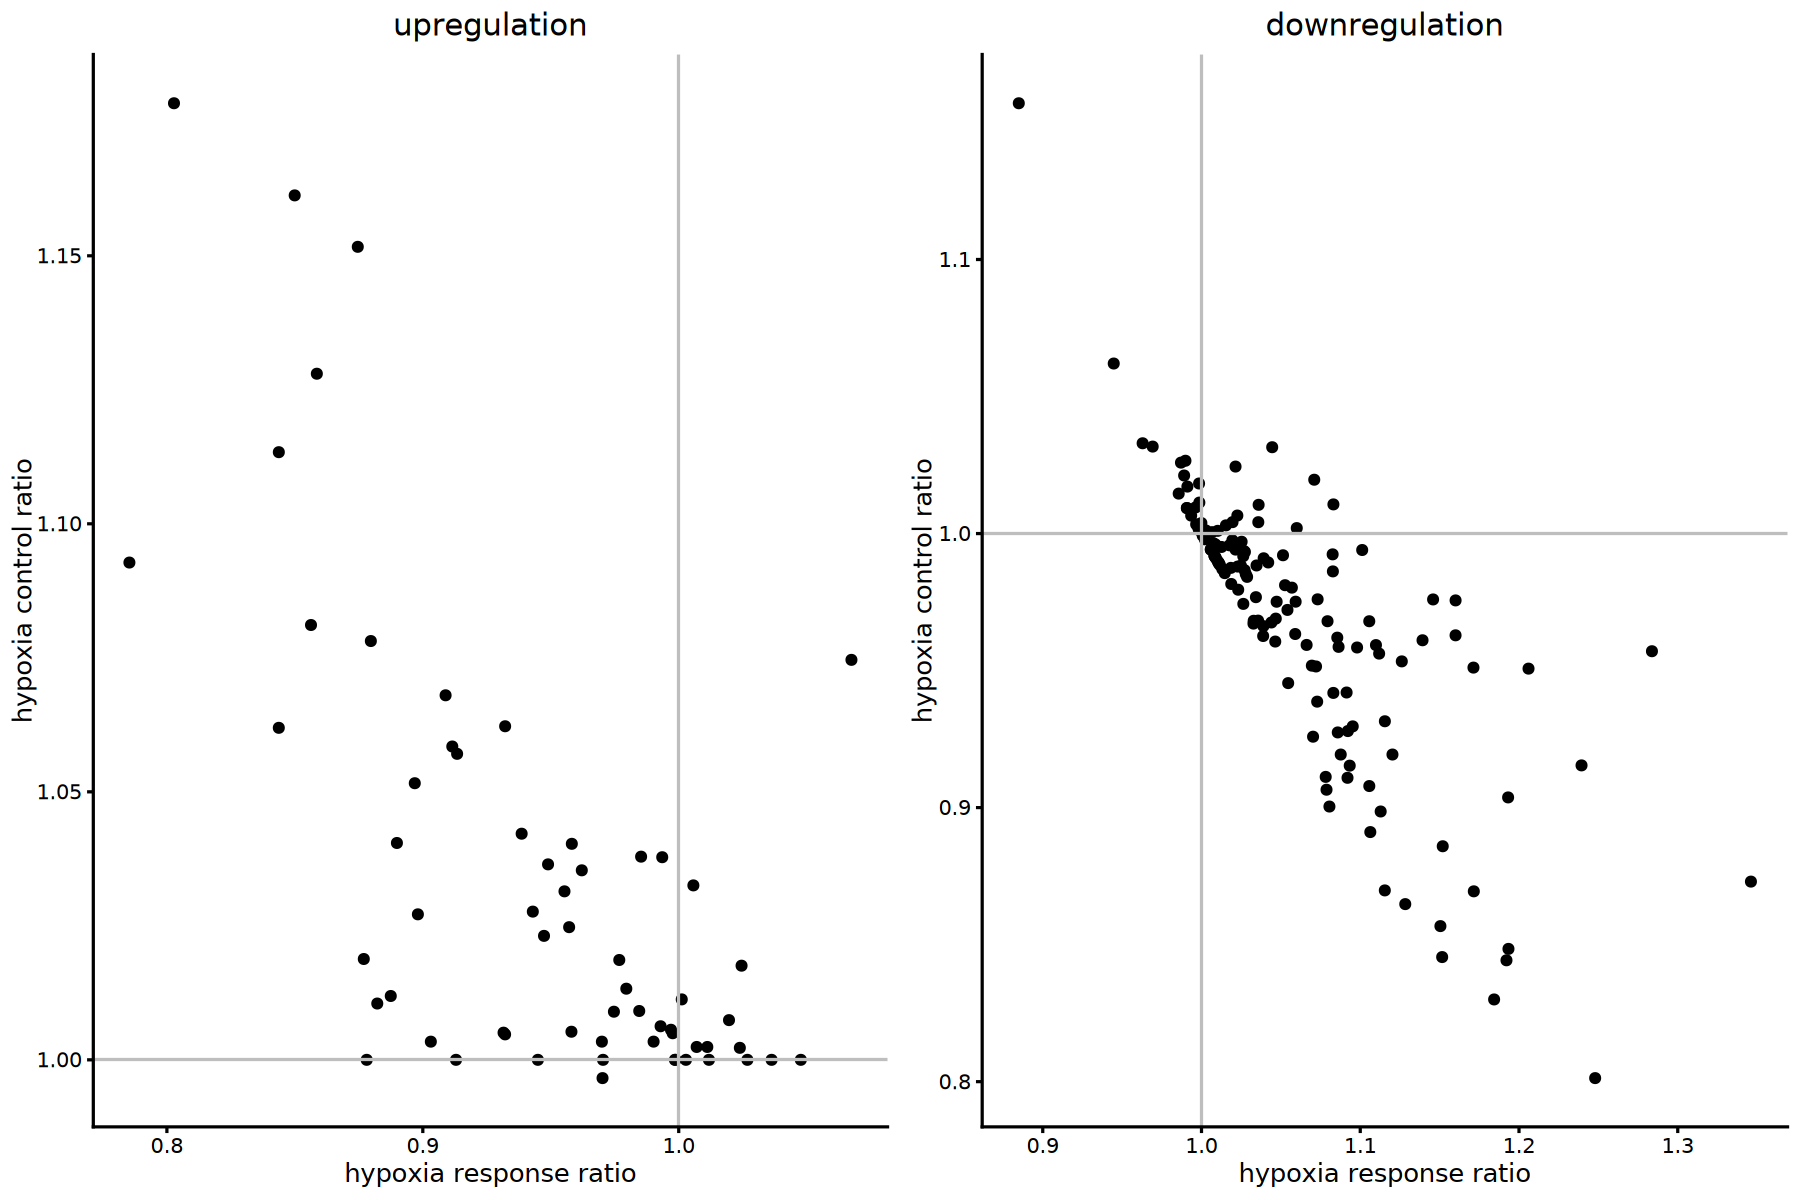

In [66]:
options(repr.plot.width=15, repr.plot.height=10)

plot_grid(hyp.UP.plot, hyp.DOWN.plot)

i'm actually not sure if i did the down-regulated genes correctly